# Fully process xenium_ffpe_shapes from xenium_read

18JAN24

In [152]:
import numpy as np
import pandas as pd
import scanpy as sc
import decoupler as dc
import geopandas
import bento as bt
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import shapely

In [19]:
# data directory
adata = bt.io.read_h5ad("Xenium_FFPE_shapes.h5ad")
adata

AnnData object with n_obs × n_vars = 166520 × 541
    obs: 'cell_shape', 'nucleus_shape', 'batch'
    uns: 'points'

### Need array based adata.obsm['spatial]

In [20]:
# could not just use get_coordinates() like in geopandas current version; no way to convert points to just list of (x,y), need to DIY.
adata.obsm["spatial"] = bt.geo.get_shape(adata, "cell_shape").centroid

# convert to array other wise bugs out at filtering

spatial_coordinates = []
for point in adata.obsm["spatial"]:
    spatial_coordinates.append([point.x, point.y])

adata.obsm["spatial"] = np.asarray(spatial_coordinates)
adata.obsm["spatial"]

array([[ 847.18355615,  326.09719216],
       [ 826.15610713,  327.99878944],
       [ 839.64174136,  351.06170043],
       ...,
       [3655.51974264, 1368.9154971 ],
       [3691.89167208, 1375.94393309],
       [3670.2228581 , 1375.06509097]])

### QC and filter

In [21]:
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)

In [22]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [23]:
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=5)

### Dimensionality reduction

In [24]:
sc.tl.pca(adata, svd_solver="arpack")  # generate PCA features
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)  # compute distances in PCA space
sc.tl.umap(adata)

In [25]:
sc.tl.leiden(adata, key_added="leiden_res0.8", resolution=0.8)
sc.tl.leiden(adata, key_added="leiden_res1.0", resolution=1.0)
sc.tl.leiden(adata, key_added="leiden_res1.2", resolution=1.2)

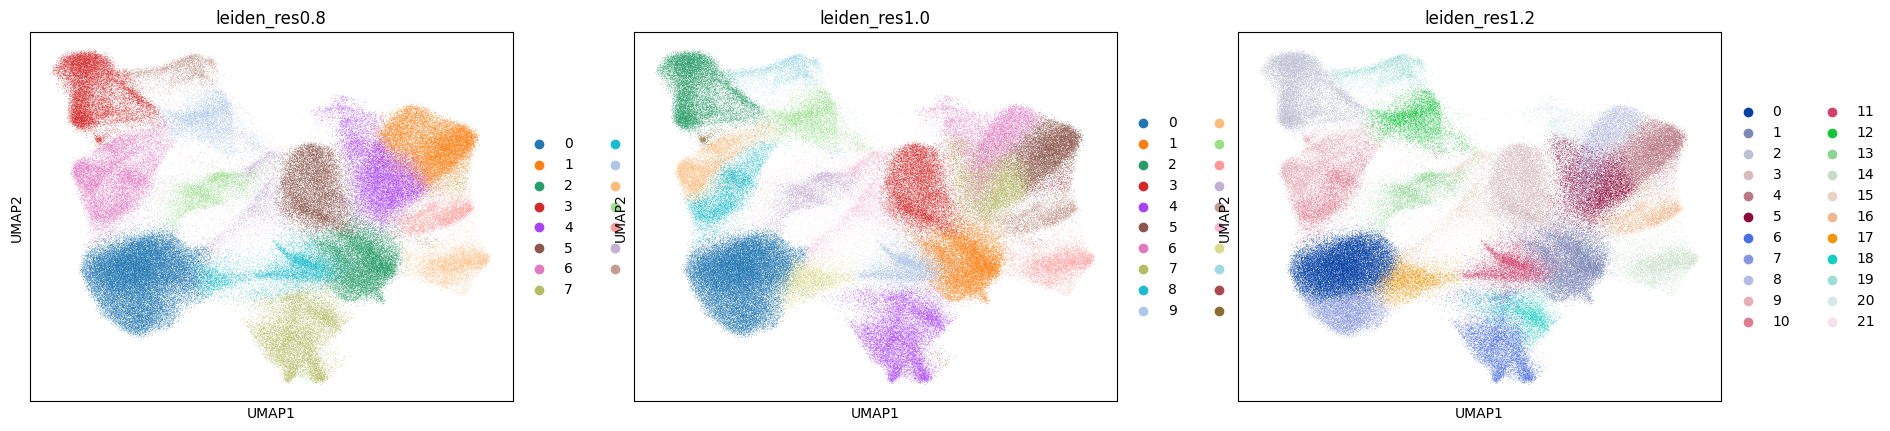

In [26]:
sc.pl.umap(adata, color=["leiden_res0.8", "leiden_res1.0", "leiden_res1.2"], ncols=3)

<AxesSubplot:title={'center':'Unique transcripts per cell'}, xlabel='n_genes_by_counts', ylabel='Count'>

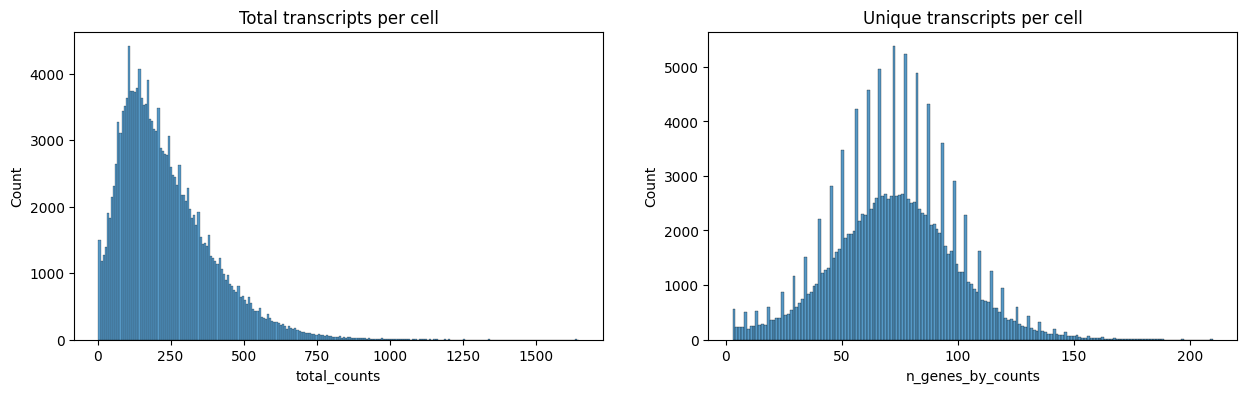

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)

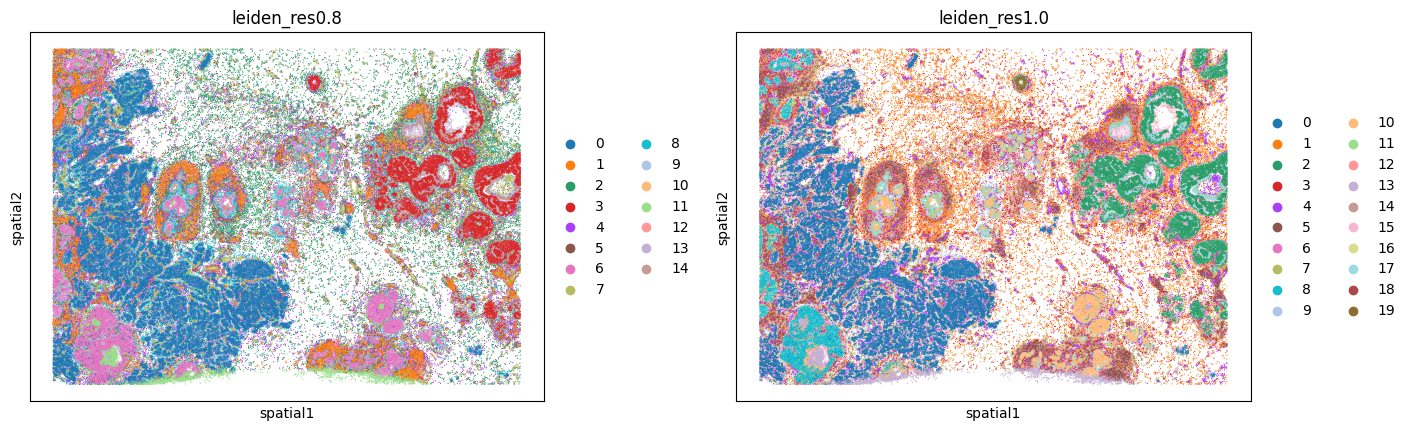

In [32]:
sc.pl.embedding(
    adata,
    basis="spatial",
    color=["leiden_res0.8", "leiden_res1.0"],
    wspace=0.25,
    size=3,
)

# Cell typing

Cluster and see what looks most appropriate with per cluster geometry; selecting res 1.0

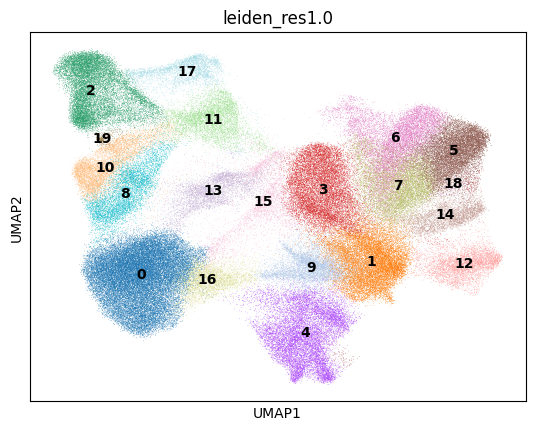

In [47]:
sc.pl.umap(
    adata,
    color=[
        "leiden_res1.0",
    ],
    wspace=0.1,
    legend_loc="on data",
)

In [46]:
# sc.pl.umap(
#     adata,
#     color=["CD8A"],
#     wspace=0.1,
#     legend_loc="on data",
# )

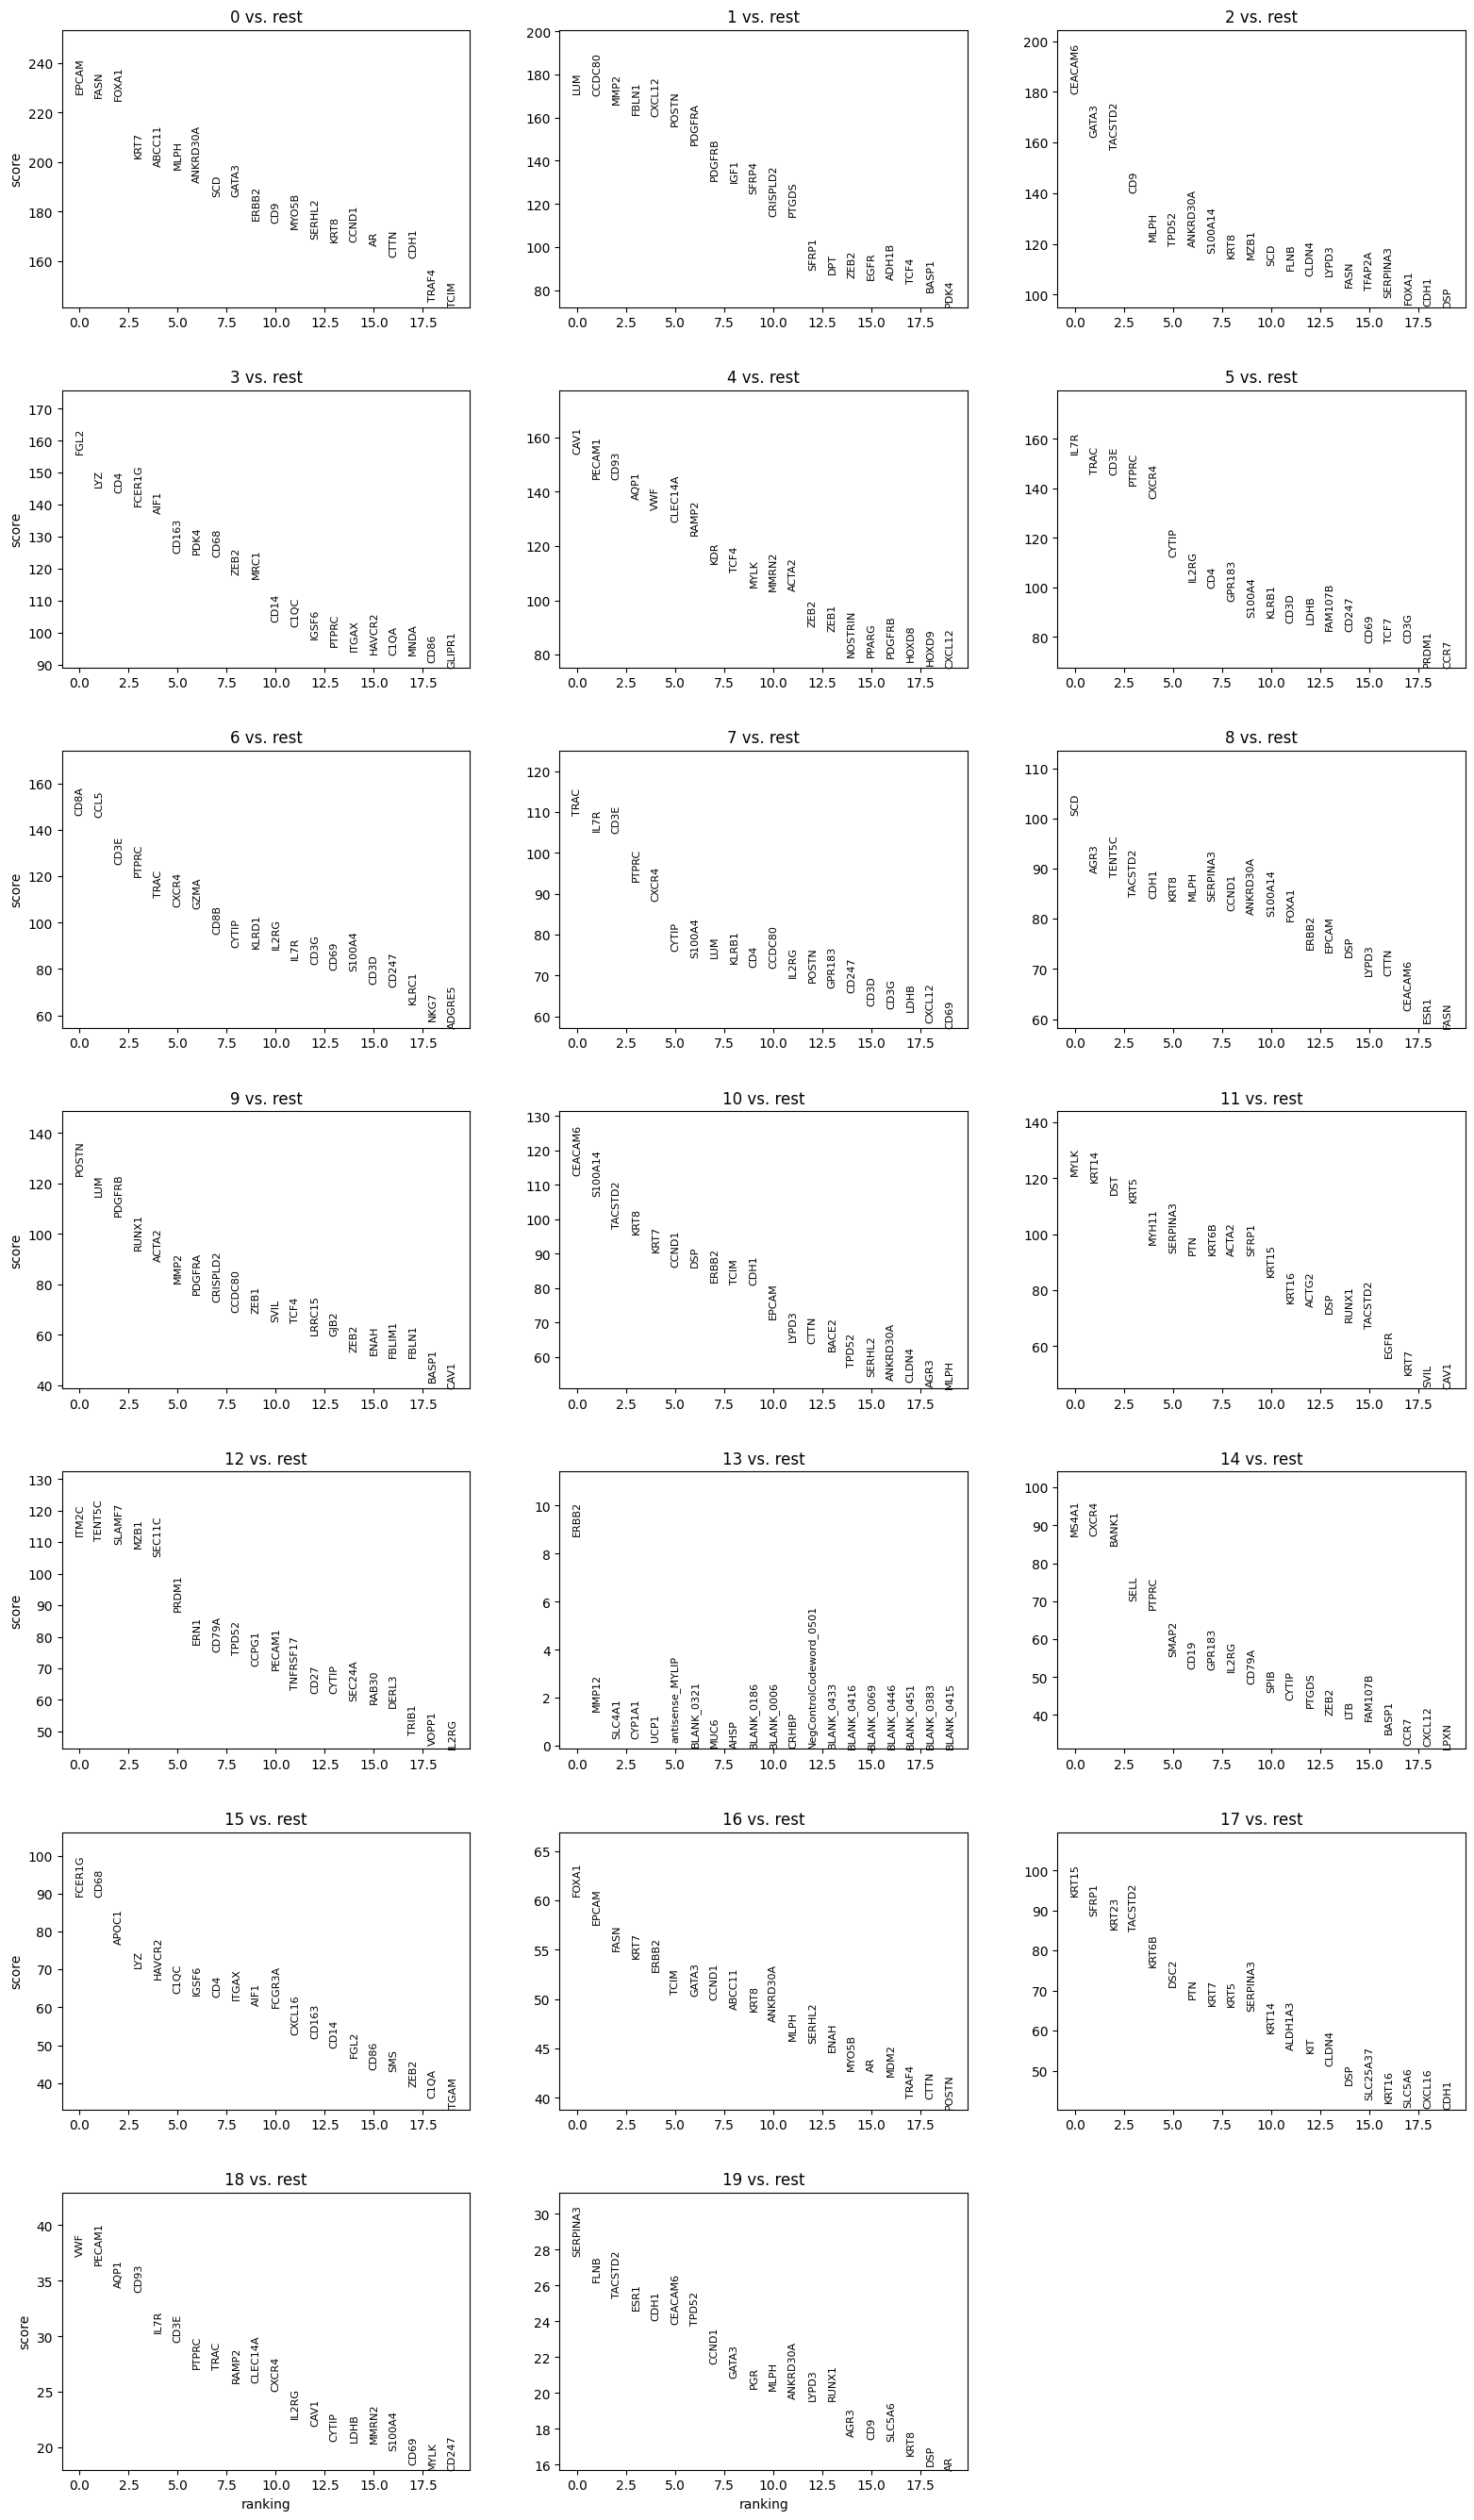

In [44]:
sc.tl.rank_genes_groups(adata, "leiden_res1.0", method="wilcoxon", key_added="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, ncols=3, key="wilcoxon")

In [59]:
# res0.8
def cell_typing(value):
    if value == "0":
        return "invasive tumor"
    if value == "1":
        return "fibroblast"
    if value == "2":
        return "DCIS 1"
    if value == "3":
        return "macrophages"
    if value == "4":
        return "endothelial"
    if value == "5":
        return "CD4+ T cells"
    if value == "6":
        return "CD8+ T cells"
    if value == "7":
        return "CD4+ T cells"
    if value == "8":
        return "DCIS 2"
    if value == "9":
        return "stromal"
    if value == "10":
        return "DCIS 2"
    if value == "11":
        return "myoepithelial ACTA2+"
    if value == "12":
        return "plasma cells"
    if value == "13":
        return "low qc"
    if value == "14":
        return "B cells"
    if value == "15":
        return "TAMs"
    if value == "16":
        return "invasive tumor"
    if value == "17":
        return "myoepithelial KRT15+"
    if value == "18":
        return "low QC"
    if value == "19":
        return "triple positive"

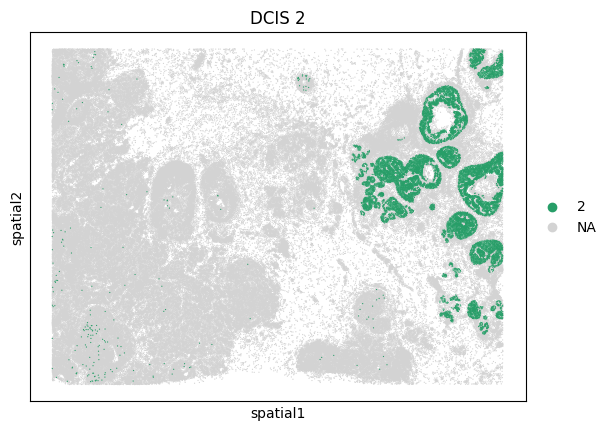

In [64]:
sc.pl.embedding(
    adata,
    basis="spatial",
    color=["leiden_res1.0"],
    groups="2",
    wspace=0.25,
    size=3,
    title="DCIS 2",
)

In [63]:
# run cell typing
adata.obs["cell_type"] = adata.obs["leiden_res1.0"].map(cell_typing)
adata.obs["cell_type"]

cell
0                low qc
1                DCIS 2
10               low qc
100              DCIS 2
1000             DCIS 2
              ...      
99995            DCIS 2
99996    invasive tumor
99997      CD8+ T cells
99998    invasive tumor
99999      CD4+ T cells
Name: cell_type, Length: 165573, dtype: object

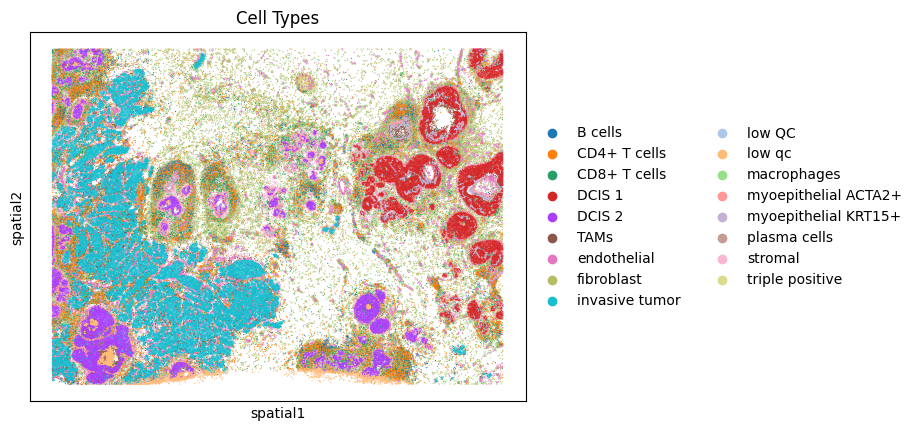

In [65]:
sc.pl.embedding(
    adata,
    basis="spatial",
    color=["cell_type"],
    wspace=0.25,
    size=3,
    title="Cell Types",
)

### Rank genes final

In [1]:
sc.tl.dendrogram(adata, "cell_type")
sc.tl.rank_genes_groups(adata, "cell_type")

NameError: name 'sc' is not defined

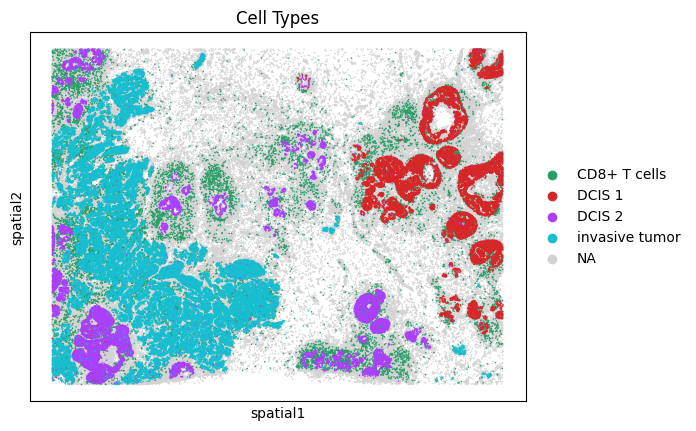

In [67]:
sc.pl.embedding(
    adata,
    basis="spatial",
    color=["cell_type"],
    wspace=0.25,
    size=5,
    groups=["invasive tumor", "DCIS 1", "DCIS 2", "CD8+ T cells"],
    title="Cell Types",
)

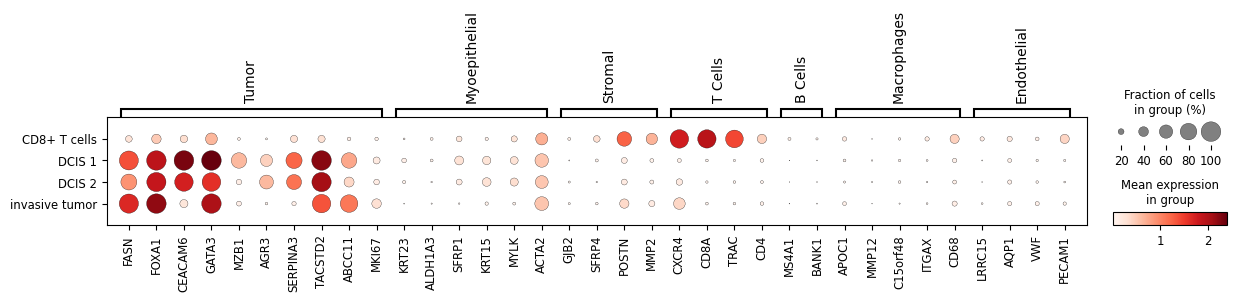

In [71]:
adata_1b = adata[
    adata.obs["cell_type"].isin(["invasive tumor", "DCIS 1", "DCIS 2", "CD8+ T cells"])
]

var_names = {
    "Tumor": [
        "FASN",
        "FOXA1",
        "CEACAM6",
        "GATA3",
        "MZB1",
        "AGR3",
        "SERPINA3",
        "TACSTD2",
        "ABCC11",
        "MKI67",
    ],
    "Myoepithelial": ["KRT23", "ALDH1A3", "SFRP1", "KRT15", "MYLK", "ACTA2"],
    "Stromal": ["GJB2", "SFRP4", "POSTN", "MMP2"],
    "T Cells": ["CXCR4", "CD8A", "TRAC", "CD4"],
    "B Cells": ["MS4A1", "BANK1"],
    "Macrophages": ["APOC1", "MMP12", "C15orf48", "ITGAX", "CD68"],
    "Endothelial": ["LRRC15", "AQP1", "VWF", "PECAM1"],
}

sc.pl.rank_genes_groups_dotplot(
    adata_1b,
    var_names=var_names,
    dendrogram=False,
    groups=["DCIS 1", "DCIS 2", "invasive tumor", "CD8+ T cells"],
)

<AxesSubplot:>

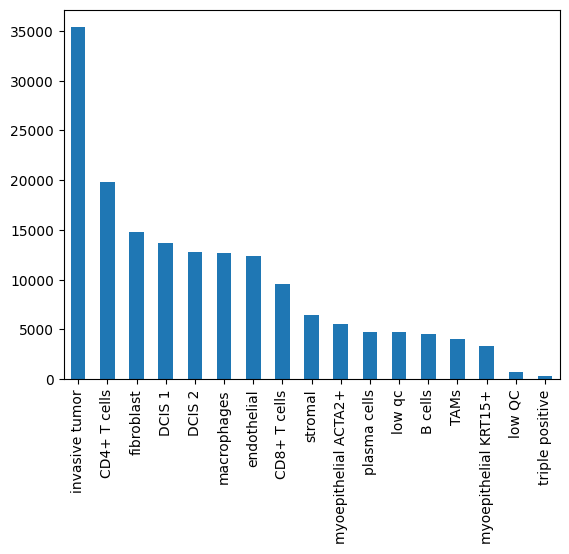

In [94]:
adata.obs["cell_type"].value_counts().plot(kind="bar")

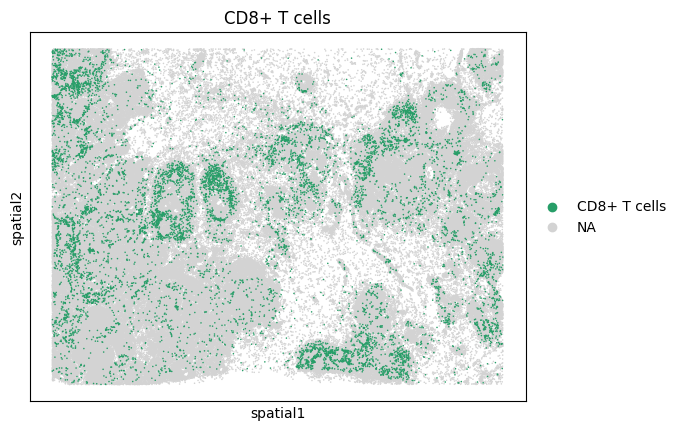

In [109]:
sc.pl.embedding(
    adata,
    basis="spatial",
    color=["cell_type"],
    wspace=0.25,
    size=5,
    groups=["CD8+ T cells"],
    title="CD8+ T cells",
)

In [96]:
adata.obs["total_counts"].describe()

count    165573.000000
mean        234.164963
std         155.144806
min           3.000000
25%         119.000000
50%         202.000000
75%         317.000000
max        1647.000000
Name: total_counts, dtype: float64

In [150]:
adata

AnnData object with n_obs × n_vars = 165573 × 541
    obs: 'cell_shape', 'nucleus_shape', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden_res0.8', 'leiden_res1.0', 'leiden_res1.2', 'cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'points', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_res0.8_colors', 'leiden_res1.0_colors', 'leiden_res1.2_colors', 'wilcoxon', 'cell_type_colors', 'dendrogram_cell_type', 'rank_genes_groups'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

## Pre Bento Requirements

In [72]:
# Bento requirements

adata.uns["points"]["batch"] = 0

# Cast cell as str for density plot
adata.uns["points"]["cell"] = adata.uns["points"]["cell"].astype(str)

# change to cat
adata.uns["points"]["gene"] = adata.uns["points"]["gene"].astype("category")

In [164]:
from shapely.geometry import MultiPolygon, Polygon

In [177]:
adata.shape

(165573, 541)

In [179]:
adata = adata[~adata.obs["nucleus_shape"].apply(lambda poly: isinstance(poly, MultiPolygon))]
adata = adata[~adata.obs["cell_shape"].apply(lambda poly: isinstance(poly, MultiPolygon))]

adata.shape

(165539, 541)

## Subset data per cell type

Generate 1000x1000 size crops each with 770 (greatest common number of cells per 4 crops) and plot. For cells that have >770 cells, take random sample of 770 cells with `random.seed(10)`

In [181]:
import random

random.seed(10)

In [182]:
# cell types relevant for analysis

inv_tumor = adata[adata.obs["cell_type"] == "invasive tumor"]
dcis1 = adata[adata.obs["cell_type"] == "DCIS 1"]
dcis2 = adata[adata.obs["cell_type"] == "DCIS 2"]
cd8 = adata[adata.obs["cell_type"] == "CD8+ T cells"]

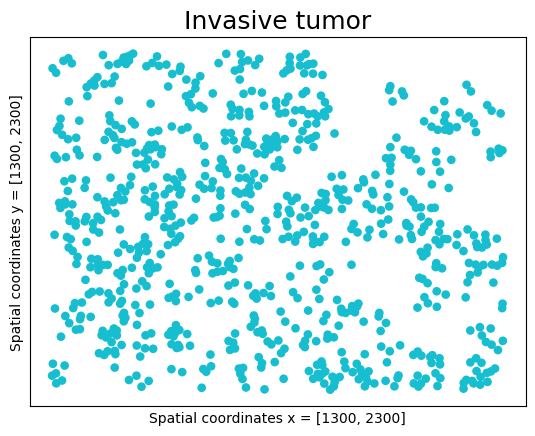

In [217]:
# crops per cell type
inv_tumor_crop = bt.geo.crop(inv_tumor, [1300, 2300], [1300, 2300])
inv_tumor_crop = inv_tumor_crop[random.sample(range(0, len(inv_tumor_crop)), 770)]
ax = sc.pl.embedding(
    inv_tumor_crop,
    basis="spatial",
    color="cell_type",
    wspace=0.4,
    title="Invasive tumor",
    legend_loc=None,
    show=False,
)
_ = ax.set_xlabel("Spatial coordinates x = [1300, 2300]", fontsize=10)
_ = ax.set_ylabel("Spatial coordinates y = [1300, 2300]", fontsize=10)
_ = ax.title.set_size(18)

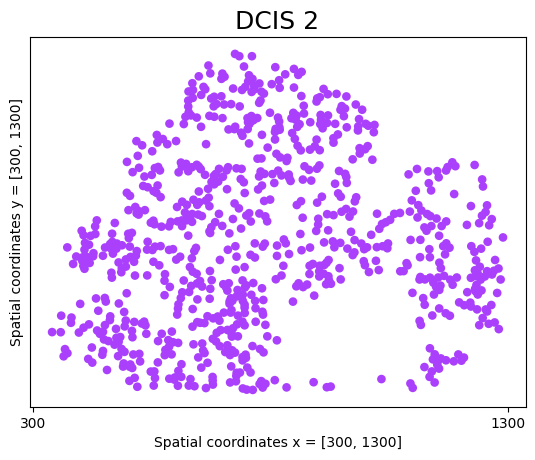

In [218]:
# crops per cell type
dcis2_crop = bt.geo.crop(dcis2, [300, 1300], [300, 1300])
dcis2_crop = dcis2_crop[random.sample(range(0, len(dcis2_crop)), 770)]
ax = sc.pl.embedding(
    dcis2_crop,
    basis="spatial",
    color="cell_type",
    wspace=0.4,
    title="DCIS 2",
    legend_loc=None,
    show=False,
)

_ = ax.set_xlabel("Spatial coordinates x = [300, 1300]", fontsize=10)
_ = ax.set_ylabel("Spatial coordinates y = [300, 1300]", fontsize=10)
_ = ax.title.set_size(18)
_ = ax.set_xticks([300, 1300])

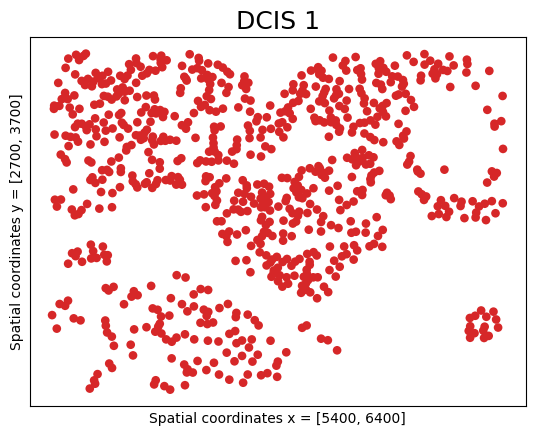

In [219]:
# crops per cell type
dcis1_crop = bt.geo.crop(dcis1, [5400, 6400], [2700, 3700])
dcis1_crop = dcis1_crop[random.sample(range(0, len(dcis1_crop)), 770)]
ax = sc.pl.embedding(
    dcis1_crop,
    basis="spatial",
    color="cell_type",
    wspace=0.4,
    title="DCIS 1",
    legend_loc=None,
    show=False,
)

_ = ax.set_xlabel("Spatial coordinates x = [5400, 6400]", fontsize=10)
_ = ax.set_ylabel("Spatial coordinates y = [2700, 3700]", fontsize=10)
_ = ax.title.set_size(18)

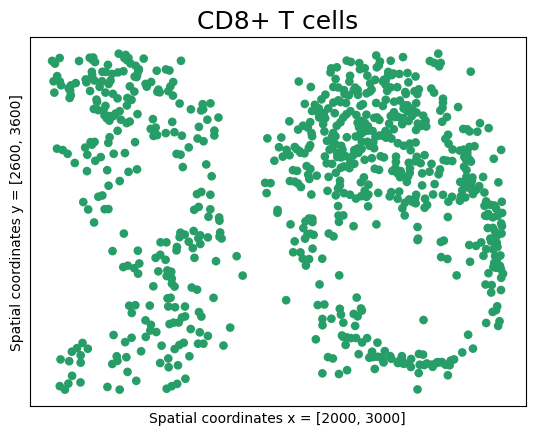

In [220]:
# crops per cell type
cd8_crop = bt.geo.crop(cd8, [2000, 3000], [2600, 3600])
ax = sc.pl.embedding(
    cd8_crop,
    basis="spatial",
    color="cell_type",
    wspace=0.4,
    title="CD8+ T cells",
    legend_loc=None,
    show=False,
)

_ = ax.set_xlabel("Spatial coordinates x = [2000, 3000]", fontsize=10)
_ = ax.set_ylabel("Spatial coordinates y = [2600, 3600]", fontsize=10)
_ = ax.title.set_size(18)

# Run Bento

In [221]:
def get_geometries(adata):
    bt.tl.obs_stats(adata)
    bt.tl.analyze_shapes(
        adata,
        ["cell_shape", "nucleus_shape"],
        ["radius", "aspect_ratio", "area", "density"],
    )
    bt.pl.obs_stats(
        adata,
        obs_cols=[
            "cell_radius",
            "cell_aspect_ratio",
            "cell_area",
            "cell_density",
            "nucleus_radius",
            "nucleus_aspect_ratio",
            "nucleus_area",
            "nucleus_density",
        ],
    )

    return adata

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

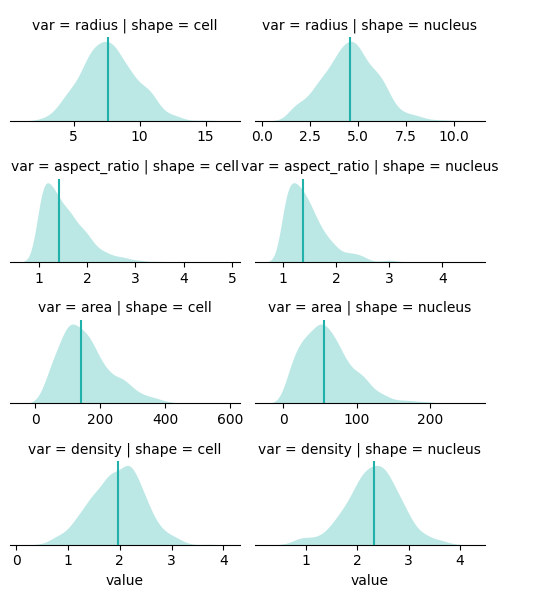

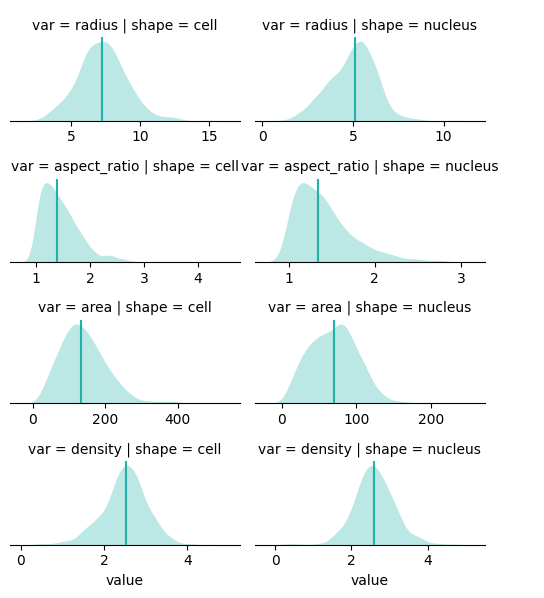

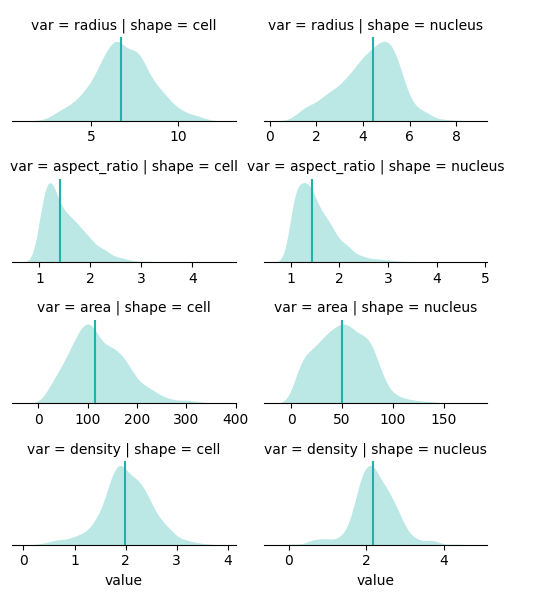

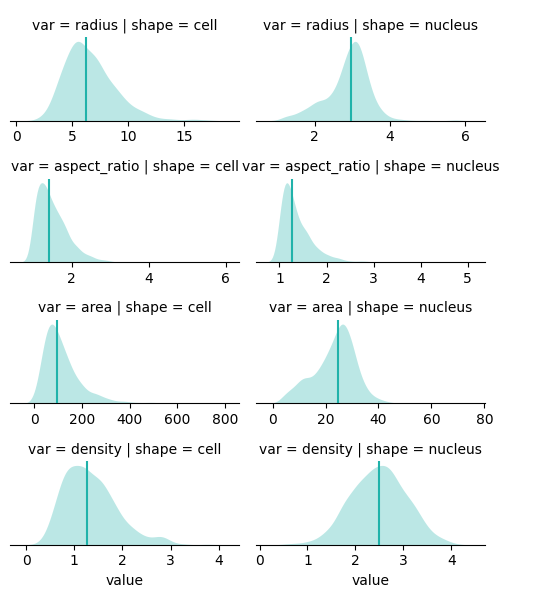

In [222]:
datasets = [inv_tumor_crop, dcis1_crop, dcis2_crop, cd8_crop]
for sample in datasets:
    get_geometries(sample)

In [223]:
def rnaFlux(adata):
    res = 1
    mean_radius = adata.obs["cell_radius"].mean()
    bt.tl.flux(adata, radius=mean_radius / 2, res=res)
    bt.pl.flux(adata, res=res)

In [ ]:
datasets = [inv_tumor_crop, dcis1_crop, dcis2_crop, cd8_crop]
for sample in datasets:
    rnaFlux(sample)

Text(0.5, 1.0, 'Inv Tumor')

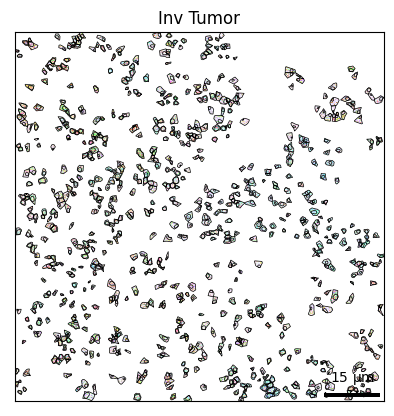

In [268]:
bt.pl.flux(inv_tumor_crop, res=1)
plt.title("Inv Tumor")

Text(0.5, 1.0, 'Individual cells')

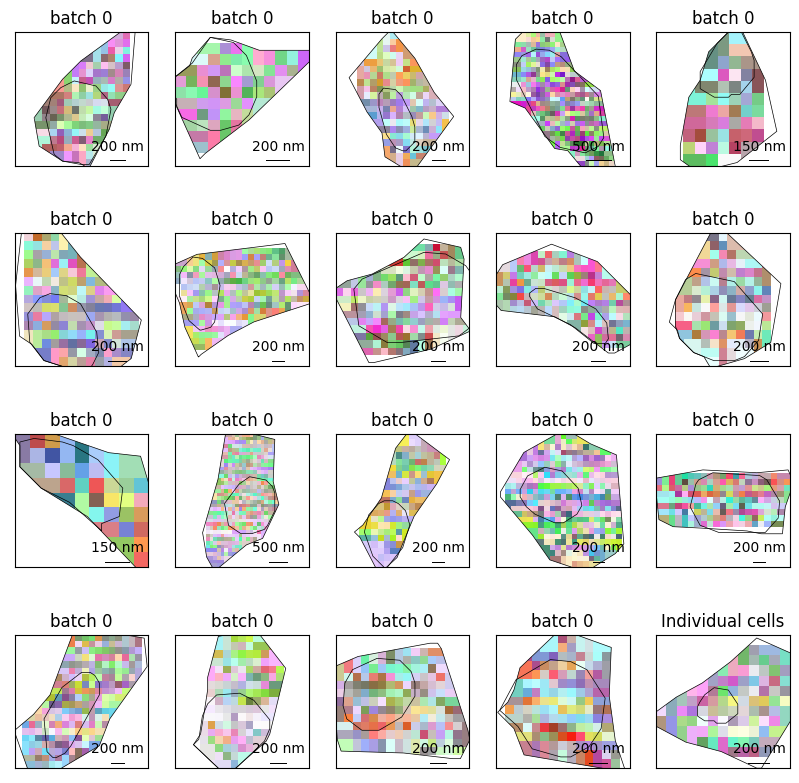

In [274]:
i = [x for x in range(1, 21)]
fig, axes = plt.subplots(4, 5, figsize=(10, 10))
for i, ax in zip(i, axes.flat):
    bt.pl.flux(inv_tumor_crop[i], ax=ax, res=1, square=True, title="")

plt.title("Individual cells")

Text(0.5, 1.0, 'DCIS 1')

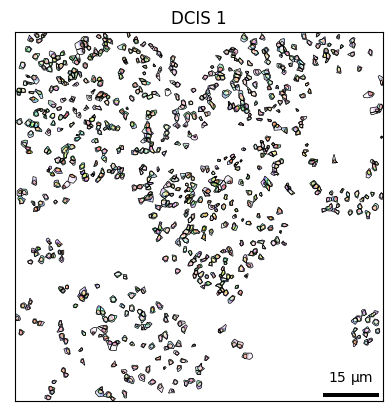

In [269]:
bt.pl.flux(dcis1_crop, res=1)
plt.title("DCIS 1")

Text(0.5, 1.0, 'Individual cells')

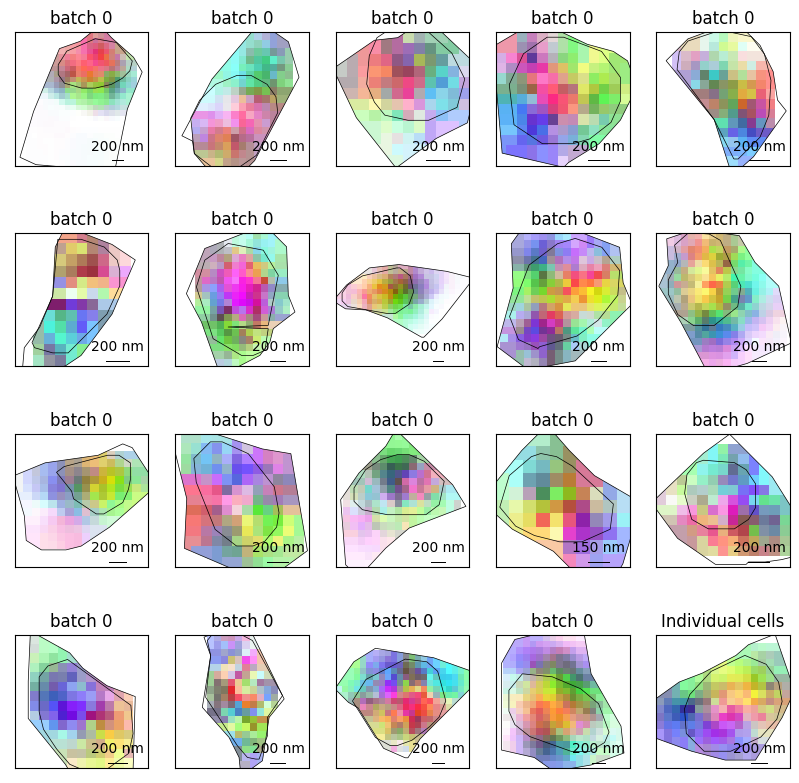

In [273]:
i = [x for x in range(1, 21)]
fig, axes = plt.subplots(4, 5, figsize=(10, 10))
for i, ax in zip(i, axes.flat):
    bt.pl.flux(dcis1_crop[i], ax=ax, res=1, square=True, title="")

plt.title("Individual cells")

Text(0.5, 1.0, 'DCIS 2')

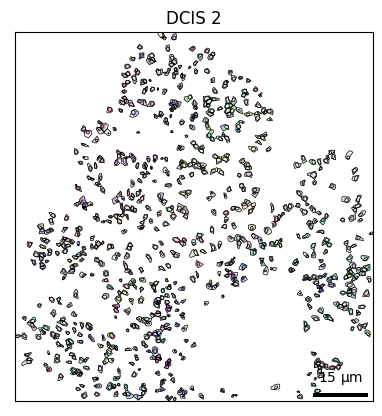

In [270]:
bt.pl.flux(dcis2_crop, res=1)
plt.title("DCIS 2")

Text(0.5, 1.0, 'Individual cells')

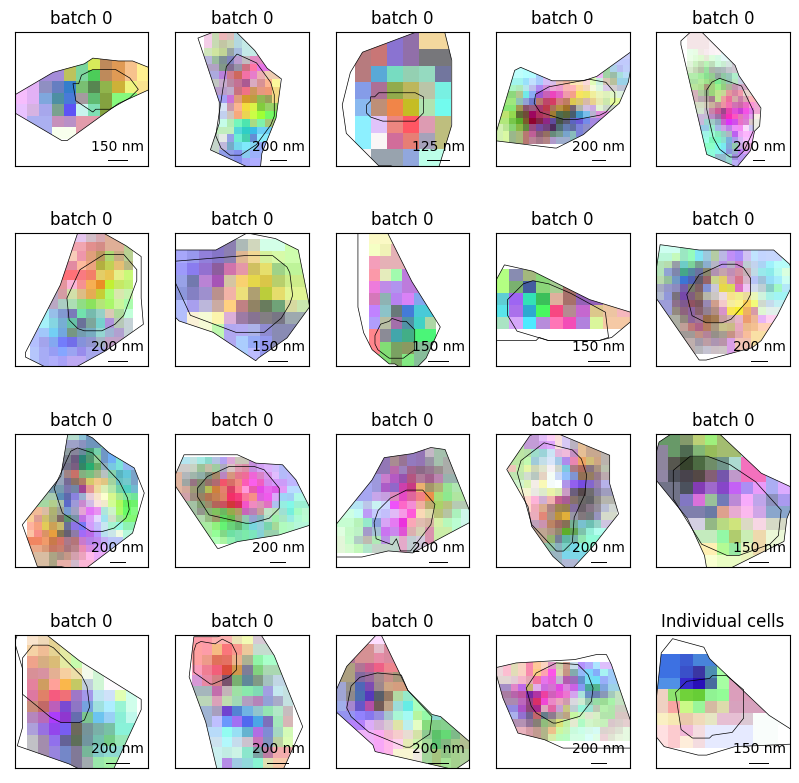

In [275]:
i = [x for x in range(1, 21)]
fig, axes = plt.subplots(4, 5, figsize=(10, 10))
for i, ax in zip(i, axes.flat):
    bt.pl.flux(dcis2_crop[i], ax=ax, res=1, square=True, title="")

plt.title("Individual cells")

Text(0.5, 1.0, 'CD8+ T cells')

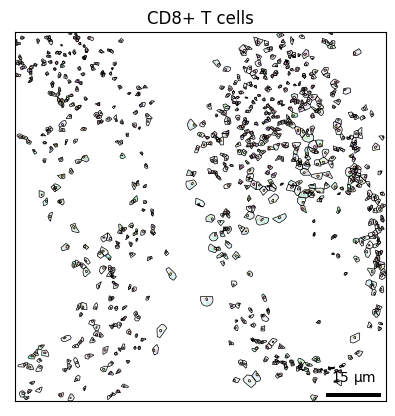

In [271]:
bt.pl.flux(cd8_crop, res=1)
plt.title("CD8+ T cells")

Text(0.5, 1.0, 'Individual cells')

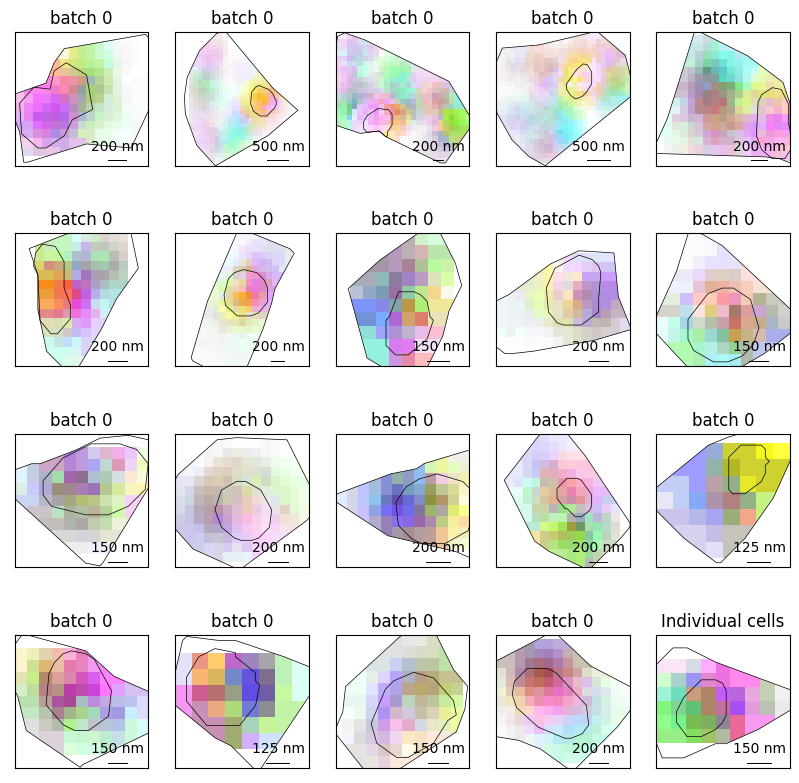

In [276]:
i = [x for x in range(1, 21)]
fig, axes = plt.subplots(4, 5, figsize=(10, 10))
for i, ax in zip(i, axes.flat):
    bt.pl.flux(cd8_crop[i], ax=ax, res=1, square=True, title="")

plt.title("Individual cells")